# Automated rule-based Bayesian regression analysis for the 1D advection data

Load the packages

In [13]:
from cycler import cycler

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import arviz as az
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")

Create the data

In [3]:
np.random.seed(1000005)
scale = 0.002

y_true = np.load("data_y_true.npy")
x = np.load("data_x.npy")
y_true = y_true * 10
shape = y_true.shape
times = shape[0]

noise = np.random.normal(scale=scale, size=shape)
y = y_true + noise
y_flat = y.flatten()

Create the B-splines

In [4]:
N_KNOT = 10
knots = np.linspace(0, 2 * np.pi, N_KNOT)
N_MODEL_KNOTS = 5 * N_KNOT
basis_funcs = sp.interpolate.BSpline(knots, np.eye(N_MODEL_KNOTS), k=3)

Plot the data

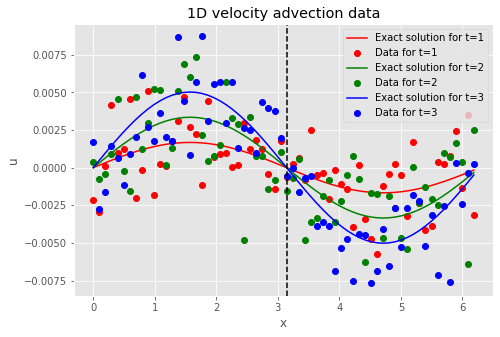

In [5]:
colors = ["red", "green", "blue"]
fig = plt.figure(figsize=(7.5, 5))
ax = fig.gca()
for i in range(times):
    plt.plot(
        x, y_true[i, :], color=colors[i], label="Exact solution for t=" + str(i + 1)
    )
    plt.plot(x, y[i, :], "o", color=colors[i], label="Data for t=" + str(i + 1))
plt.axvline(x=np.pi, linestyle="--", c="k")
ax.set_ylabel("u")
ax.set_xlabel("x")
ax.set_title("1D velocity advection data")
ax.legend(ncol=2, fontsize=10)
ax.legend()
#fig.savefig("1Dadv_data", dpi=300)

Save the data

In [6]:
#np.savetxt("y_true_data.csv", y_true.T, delimiter=",")
#np.savetxt("y_data.csv", y.T, delimiter=",")
#np.savetxt("x_data.csv", x.T, delimiter=",")

Create classes for the basis functions of the splines

In [7]:
class BasisFunc:
    def __init__(self):
        """
        Initialize the class
        """
        self.Bx = None
        self.Bx_ = None

    def create_basis(self, x):
        """
        Create the basis object
        """
        Bx = basis_funcs(x)
        Bx_ = theano.shared(Bx)

        self.Bx = Bx
        self.Bx_ = Bx_


class RuleBasisFunc(BasisFunc):
    def __init__(self):
        """
        Initialize the class
        """
        super().__init__()
        self.discr = None

    def create_discr(self, no_points, min, max):
        """
        Create discretization
        """
        self.discr = np.linspace(min, max, no_points)

Define the rules

In [8]:
no_points = 25
xlow = 0
xmid = np.pi
xhi = 2 * np.pi

data_base = BasisFunc()
data_base.create_basis(x)

rule_first_y1y2 = RuleBasisFunc()
rule_first_y1y2.create_discr(no_points, xlow, 2.6)
rule_first_y1y2.create_basis(rule_first_y1y2.discr)

rule_first_y2y3 = RuleBasisFunc()
rule_first_y2y3.create_discr(no_points, xlow, 3.6)
rule_first_y2y3.create_basis(rule_first_y2y3.discr)


rule_second_y1y2 = RuleBasisFunc()
rule_second_y1y2.create_discr(no_points, 2.6, xhi)
rule_second_y1y2.create_basis(rule_second_y1y2.discr)

rule_second_y2y3 = RuleBasisFunc()
rule_second_y2y3.create_discr(no_points, 3.6, xhi)
rule_second_y2y3.create_basis(rule_second_y2y3.discr)

Define the rule function

In [9]:
def logp_rule(a0, σ_a, Δ_a):
    """
    Construct the rule penalty
    """

    a = a0 + (σ_a * Δ_a).cumsum(axis=0)

    points_r1_y1y2 = rule_first_y1y2.Bx_.dot(a).T.flatten()
    points_r1_y2y3 = rule_first_y2y3.Bx_.dot(a).T.flatten()
    points_r2_y1y2 = rule_second_y1y2.Bx_.dot(a).T.flatten()
    points_r2_y2y3 = rule_second_y2y3.Bx_.dot(a).T.flatten()

    rule_log_lik = 0
    for i in range(no_points):

        num = 0

        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.lt(
                points_r1_y1y2[i + (num + 1) * no_points],
                points_r1_y1y2[i + num * no_points],
            ),
            1,
            0,
        )

        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.gt(
                points_r2_y1y2[i + (num + 1) * no_points],
                points_r2_y1y2[i + num * no_points],
            ),
            1,
            0,
        )

        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.lt(
                points_r1_y2y3[i + (num + 2) * no_points],
                points_r1_y2y3[i + (num + 1) * no_points],
            ),
            1,
            0,
        )

        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.gt(
                points_r2_y2y3[i + (num + 2) * no_points],
                points_r2_y2y3[i + (num + 1) * no_points],
            ),
            1,
            0,
        )

    rule_ratio = rule_log_lik / (2 * 2 * no_points)

    return pm.Beta.dist(alpha=1.0, beta=100.0).logp(rule_ratio)

Run the model

In [10]:
use_rule = True

with pm.Model() as model:
    σ_a = pm.HalfCauchy("σ_a", 0.1, shape=times)
    a0 = pm.Normal("a0", 0.0, 0.1, shape=times)
    Δ_a = pm.Normal("Δ_a", 0.0, 5.0, shape=(N_MODEL_KNOTS, times))
    a = pm.Deterministic("a", a0 + (σ_a * Δ_a).cumsum(axis=0))

    res = data_base.Bx_.dot(a)
    res_fl = res.T.flatten()

    obs = pm.Normal("obs", res_fl, scale, observed=y_flat)
    if use_rule:
        LL_rule = pm.Potential("LL_rule", logp_rule(a0, σ_a, Δ_a))

with model:
    trace = pm.sample_smc(draws=10000)

Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.723
Stage:   2 Beta: 0.000 Steps:   3 Acce: 0.626
Stage:   3 Beta: 0.000 Steps:   4 Acce: 0.571
Stage:   4 Beta: 0.000 Steps:   5 Acce: 0.591
Stage:   5 Beta: 0.000 Steps:   5 Acce: 0.642
Stage:   6 Beta: 0.000 Steps:   4 Acce: 0.576
Stage:   7 Beta: 0.000 Steps:   5 Acce: 0.477
Stage:   8 Beta: 0.000 Steps:   7 Acce: 0.338
Stage:   9 Beta: 0.001 Steps:  11 Acce: 0.184
Stage:  10 Beta: 0.001 Steps:  22 Acce: 0.122
Stage:  11 Beta: 0.002 Steps:  25 Acce: 0.105
Stage:  12 Beta: 0.002 Steps:  25 Acce: 0.113
Stage:  13 Beta: 0.004 Steps:  25 Acce: 0.127
Stage:  14 Beta: 0.006 Steps:  25 Acce: 0.140
Stage:  15 Beta: 0.009 Steps:  25 Acce: 0.150
Stage:  16 Beta: 0.013 Steps:  25 Acce: 0.158
Stage:  17 Beta: 0.020 Steps:  25 Acce: 0.160
Stage:  18 Beta: 0.029 Steps:  25 Acce: 0.163
Stage:  19 Beta: 0.042 Steps:  25 Acce: 0.168
Stage:  20 Beta: 0.061 Steps:  25 Acce: 0.167
Stage:  

Plot the posterior

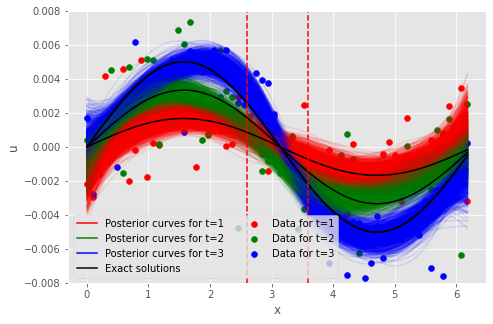

In [11]:
plt.rc("axes", prop_cycle=cycler("color", ["r", "g", "b"]))
thin = 10

fig = plt.figure(figsize=(7.5, 5))
ax = fig.gca()
for j in range(trace["a"].shape[2]):
    a = trace["a"][0 * thin, :, j]
    yvals = data_base.Bx.dot(a)
    plt.plot(x, yvals, label="Posterior curves for t=" + str(j + 1))
for iter in range(int(trace["a"].shape[0] / thin)):
    for j in range(trace["a"].shape[2]):
        a = trace["a"][iter * thin, :, j]
        yvals = data_base.Bx.dot(a)
        plt.plot(x, yvals, alpha=0.1)
for j in range(times):
    plt.scatter(x, y[j, :], label="Data for t=" + str(j + 1))
    plt.plot(x, y_true[j, :], color="k")
plt.plot(x, y_true[j, :], color="k", label="Exact solutions")
if use_rule:
    plt.axvline(x=3.6, linestyle="--")
    plt.axvline(x=2.6, linestyle="--")
ax.set_ylabel("u")
ax.set_xlabel("x")
plt.ylim([-0.008, 0.008])
ax.legend(ncol=2, fontsize=10)

#plt.savefig("1Dadv_posterior" + "_rule" * use_rule + "error.png", dpi=300)

Evaluate metrics

In [14]:
a_map = trace["a"].mean(axis=0)
yvals0_map = data_base.Bx.dot(a_map[:, 0])
yvals1_map = data_base.Bx.dot(a_map[:, 1])
yvals2_map = data_base.Bx.dot(a_map[:, 2])

yvals_full = np.c_[yvals0_map, yvals1_map, yvals2_map].T

# Metrics
mse = mean_squared_error(yvals_full, y)
mae = mean_absolute_error(yvals_full, y)

mse_true = mean_squared_error(yvals_full, y_true)
mae_true = mean_absolute_error(yvals_full, y_true)

waic = az.waic(trace, model)

with open("metrics_1Dadv.txt", "a") as text_file:
    print("Metrics linear (rules)", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)
    print(f"mse_true: {mse_true}", file=text_file)
    print(f"mae_true: {mae_true}", file=text_file)
    print(f"waic: {waic.waic}", file=text_file)

/usr/local/anaconda3/envs/burgers/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
